In [1]:
###set up

##plot size
options(repr.plot.width = 12, repr.plot.height = 8)
options(warn = -1) 
library(dplyr)
library(ggplot2)
library(ggsignif)
library(reshape2)
library(cowplot)
library(ggbeeswarm)

load("Figure1_data.RData")

##load in supplementary figure 6 data instead if wanted
#load("supp_fig6_age_accel.RData")

##melted_DAT has the age prediction errors (predicted age - real age) in "melted" data form for each 
##individual from 5 populations across 8 different age prediction metrics
head(melted_DAT)
table(melted_DAT$Pop)
unique(melted_DAT$Metric)

# choose colours
popColours <- c("Himba" = rgb(213/255, 94/255, 0/255), # red
                "KHS" = rgb(204/255, 121/255, 167/255), # purple/magenta
                "Baka" = rgb(230/255, 159/255, 0/255), # orange
                "Hispanic/Latino" = rgb(86/255, 180/255, 233/255), # blue
                "European" = rgb(0/255, 159/255, 115/255)) # green


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




,Pop,Metric,Error
,<fct>,<fct>,<dbl>
1,KHS,Horvath 2013,-4.4013449
2,KHS,Horvath 2013,1.3470032
3,KHS,Horvath 2013,-14.8239477
4,KHS,Horvath 2013,-3.7947134
5,KHS,Horvath 2013,-4.2944756
6,KHS,Horvath 2013,-0.3331789



          Himba             KHS            Baka Hispanic/Latino        European 
            392             368             280             552            1040 

[1] Horvath 2013             Hannum et al. 2013       Skin and Blood Clock    
[4] Zhang et al. 2019        PhenoAge                 FitAge                  
[7] GrimAge2 (true age)      GrimAge2 (predicted age)
8 Levels: Horvath 2013 Hannum et al. 2013 ... GrimAge2 (predicted age)

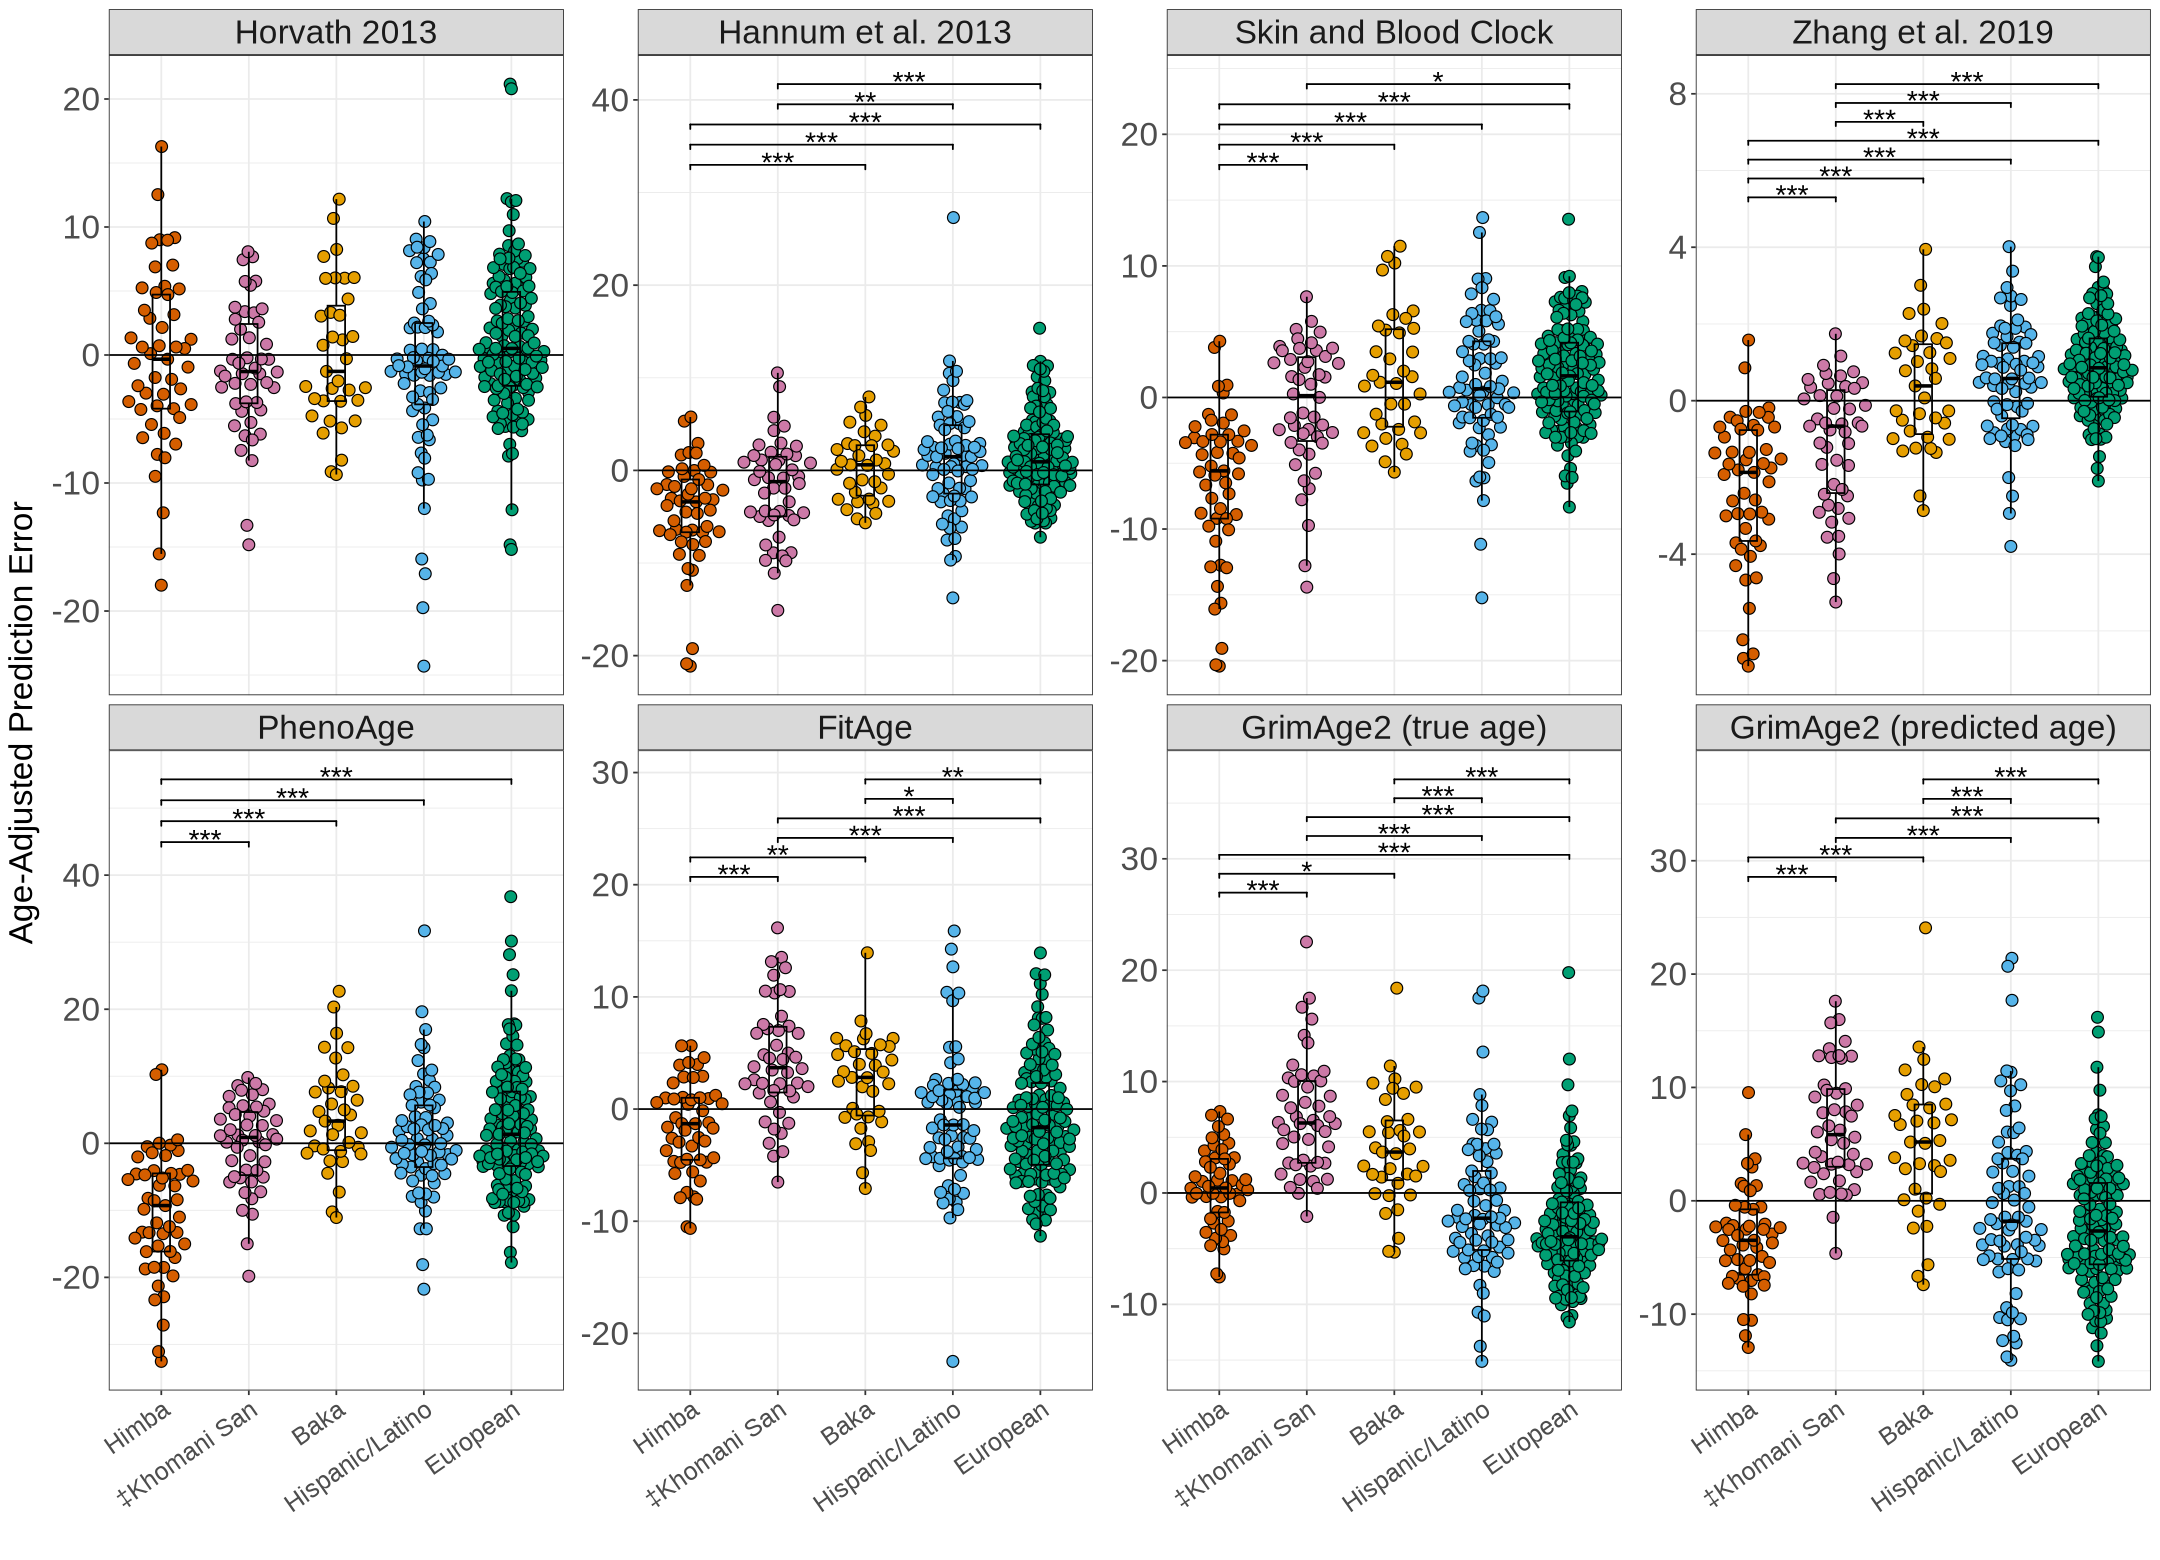

In [2]:
#####Figure 1####

f1_plotf_with_signif <- ggplot(melted_DAT, aes(x = Pop, y = Error, colour = Pop)) + 
      scale_colour_manual(values = popColours) +  # Set colors for points based on 'Pop'
      ###beeswarm + boxplot instead of violin plot
  scale_fill_manual(values = popColours) +
  geom_quasirandom(aes(fill = Pop), show.legend = FALSE, size = 3, shape = 21, color = "black") +  
      geom_boxplot(
        aes(group = Pop), outlier.shape = NA, width = 0.2, fill = NA, colour = "black"
      ) +
      geom_hline(yintercept = 0) +
      ##facet_wrap does built in paneling and one y and x label rather than repeating on each panel like in original fig 1
      facet_wrap(~Metric, nrow = 2, scales = "free_y") +  # Adjust y-axis independently per facet      
      labs(y = "Age-Adjusted Prediction Error", x = "") + #uncomment (if supp data loaded) #labs(y = "Epigenetic Age Acceleration", x = "") + #uncomment (if supp data loaded)
      theme_bw() +
  theme(
         axis.text.y = element_text(size = 20),
         axis.text.x = element_text(size=15, angle = 35, hjust = 1),
         axis.title = element_text(size = 20, margin = margin(r = 10)),
         strip.text = element_text(size = 20),
         legend.position = "none") +  # Hide the legend
      scale_x_discrete(labels = function(x) {
        ifelse(x == "KHS", "\u2021Khomani San", x)  # Replace "KHS" with "‡Khomani San"
      })

# Create a list to store significance results for ANOVA comparisons by Metric
significance_results <- list()
    # Loop through each metric to calculate significance and store results
     for (metric in unique(melted_DAT$Metric)) {
        tmp_dat <- melted_DAT[melted_DAT$Metric == metric, ]         
        # Perform ANOVA
        anova_result <- aov(lm(Error ~ Pop, tmp_dat))
         # store p-value of ANOVA 
        p_val <- summary(anova_result)[[1]]$Pr[[1]]          
        # Store Tukey results if p-value < 0.05
        if (p_val < 0.05) {
            Tukey_results <- as.data.frame(TukeyHSD(anova_result)$Pop)
            unlisted_strsplit_popnames <- unlist(strsplit(rownames(Tukey_results), "-"))
            Tukey_results$pop1 <- unlisted_strsplit_popnames[seq(1, length(unlisted_strsplit_popnames), 2)]
            Tukey_results$pop2 <- unlisted_strsplit_popnames[seq(2, length(unlisted_strsplit_popnames), 2)]          
            sig_Tukey_results <- Tukey_results[Tukey_results[,"p adj"] < 0.05, ]
            sig_Tukey_results$significance <- cut(sig_Tukey_results[, "p adj"],
                                                  breaks = c(-Inf, 0.001, 0.01, 0.05, Inf),
                                                  labels = c("***", "**", "*", "ns"))           
            # Filter significant comparisons
            sig_comparisons <- unname(mapply(c, sig_Tukey_results$pop1, sig_Tukey_results$pop2, SIMPLIFY = F))            
            # Store results in the list
            significance_results[[metric]] <- list(
              comparisons = sig_comparisons,
              annotations = sig_Tukey_results$significance
            )
          }
        }
        
## Now loop through each metric again and access the anova tukey significance results and add it to the correct facet of 
## of the facet-wrapped plot via geom_signif
    for (metric in unique(melted_DAT$Metric)) {
        # Retrieve stored significance results for the current metric
        sig_comparisons <- significance_results[[metric]]$comparisons
        annotations <- significance_results[[metric]]$annotations   
        if (!is.null(sig_comparisons)) {
            # Get y-range for the specific matric
            y_range <- range(na.omit(melted_DAT[melted_DAT$Metric == metric, "Error"]))
            # Calculate y-increment based on the y-range for each facet
            y_increment = (max(y_range) + abs(min(y_range))) * 0.045           
            # Add geom_signif to the plot for the current metric
            f1_plotf_with_signif <- f1_plotf_with_signif +
              geom_signif(
                comparisons = sig_comparisons,
                annotations = annotations,
                y_position = max(y_range) + y_increment * 1.5 + y_increment * 0:(length(sig_comparisons) - 1),
                tip_length = 0.01,
                vjust = 0.7,
                textsize = 6,
                fill = "transparent",  # Remove color fill for the significance bars
                colour = "black",  # Set the color of the significance bars to black
                data = melted_DAT[melted_DAT$Metric == metric, ]  ### Ensure it's applied only to the current facet!! ##
              )
          }
        }
options(repr.plot.width = 18, repr.plot.height = 13)

# View the final plot
f1_plotf_with_signif

